### Required Libraries

In [ ]:
%pip install pandas
%pip install nltk
%pip install scikit-learn
%pip install sklearn
%pip install matplotlib
%pip install seaborn

### Imports

In [2]:
import pandas as pd
import nltk
import numpy as np
import math
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Initial Observation of the Dataset

In [25]:
# read the dataset named emails.csv
df = pd.read_csv("emails.csv")
# print the shape of the dataset
print("Shape of the dataset is: ", df.shape)

Shape of the dataset is:  (5172, 3002)


# Preprocessing Pipeline

In [5]:
# Import the list of stop words from the 'stopwords' module
stopwordList = stopwords.words('english')

# Identify the columns in the DataFrame that have names matching any of the stop words
# Convert the stop word list and DataFrame columns to sets, find the intersection, and convert back to a list
columnsToDrop = list(set(stopwordList) & set(df.columns))

# Drop the identified columns from the DataFrame
# 'axis=1' specifies that the operation should be performed on columns (as opposed to rows)
df.drop(columnsToDrop, axis=1, inplace=True)
# the columns that have names with less than 3 characters are dropped as they would make lesser sense
for col in df.columns:
    if len(col) <3:
        df.drop(col, axis=1, inplace=True)
# Print the first few rows of the resulting DataFrame
df.head()

,Email No.,ect,hou,enron,com,gas,deal,meter,hpl,please,...,enhancements,connevey,jay,valued,lay,infrastructure,military,allowing,dry,Prediction
0,Email 1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Email 2,24,27,1,3,1,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
2,Email 3,1,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Email 4,22,10,0,0,0,2,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Email 5,17,9,0,0,2,0,3,0,1,...,0,0,0,0,0,0,0,0,0,0


Now we have 2749 features remaining out of the 3002 features, we will process more

In [37]:
# we will be using 80% of the data for training and 20% for testing
trainingDF, testingDF= train_test_split(df, test_size=0.2, random_state=42)
print("Train shape: ", trainingDF.shape)
print("Test shape: ", testingDF.shape)
# observing the mean of the train and test data to see if the split is done properly and there is lesser class imbalance
print("Train spam ratio: ", trainingDF['spam'].mean())
print("Test spam ratio: ", testingDF['spam'].mean())


Train shape:  (4137, 3002)
Test shape:  (1035, 3002)
Train spam ratio:  0.019579405366207395
Test spam ratio:  0.010628019323671498


In [38]:
# drop the columns that are not required for training as email no has no significance and prediction is the target variable
trainingDataframe = trainingDF.drop(columns=["Email No.", "Prediction"])
testingDataframe = testingDF.drop(columns=["Email No.", "Prediction"])
# calculate the initial document frequency of the words in the training data
trainingDocumentFrequency = trainingDataframe.astype(bool).sum(axis=0)
# drop the words that have a document frequency of more than 80% or less than 20% as they are not significant
for docFreq in trainingDocumentFrequency.keys():
    documentFrequencyRatio = trainingDocumentFrequency[docFreq]/len(trainingDataframe)
    if documentFrequencyRatio > 0.8 or documentFrequencyRatio < 0.2:
        trainingDataframe.drop(docFreq, axis=1, inplace=True)
        testingDataframe.drop(docFreq, axis=1, inplace=True)
# re-calculate the document frequency of the words in the training data and testing data
trainingDocumentFrequency = trainingDataframe.astype(bool).sum(axis=0)
testingDocumentFrequency = testingDataframe.astype(bool).sum(axis=0)
print("Training data shape: ", trainingDataframe.shape)
print("Testing data shape: ", testingDataframe.shape)

Training data shape:  (4137, 162)
Testing data shape:  (1035, 162)


Out of the previous 2749 features, after the feature reduction, now there are only 162 features left that makes it feasible to train our model

In [66]:
numberOfTrainingDocuments = trainingDataframe.shape[0]
print("Number of training documents: ", numberOfTrainingDocuments)
# calculating idf for each word
trainingDatasetIDF = np.log(numberOfTrainingDocuments / trainingDocumentFrequency)
testingDatasetIDF = np.log(numberOfTrainingDocuments / testingDocumentFrequency)
# observing the variances of the idf values
print("Training dataset Max IDF : ", trainingDatasetIDF.max())
print("Training dataset Min IDF : ", trainingDatasetIDF.min())
print("Testing dataset Max IDF : ", testingDatasetIDF.max())
print("Testing dataset Min IDF : ", testingDatasetIDF.min())
print("Training dataset IDF Shape : ", trainingDatasetIDF.shape)
print("Testing dataset IDF Shape : ", testingDatasetIDF.shape)


Number of training documents:  4137
Training dataset Max IDF :  1.6050963716059632
Training dataset Min IDF :  0.22513974107062182
Testing dataset Max IDF :  3.0394591357668763
Testing dataset Min IDF :  1.590759208459556
Training dataset IDF Shape :  (162,)
Testing dataset IDF Shape :  (162,)


In [69]:
# calculating tf-idf for each term in the training and testing data
trainingDatasetTFIDF = trainingDataframe * trainingDatasetIDF
testingDatasetTFIDF = testingDataframe * testingDatasetIDF
# observing the variances of the tf-idf values
print("Training dataset Max TF-IDF : ", trainingDatasetTFIDF.max()[:5])
print("Testing dataset Max TF-IDF : ", testingDatasetTFIDF.max()[:5])
print("Training dataset TF-IDF Shape : ", trainingDatasetTFIDF.shape)
print("Testing dataset TF-IDF Shape : ", testingDatasetTFIDF.shape)

Training dataset Max TF-IDF :  the    62.163316
to     25.327079
and    45.686061
for    11.530224
of     46.964607
dtype: float64
Testing dataset Max TF-IDF :  the    177.946611
to     212.350118
and    103.814876
for     62.343467
of     130.012337
dtype: float64
Training dataset TF-IDF Shape :  (4137, 162)
Testing dataset TF-IDF Shape :  (1035, 162)


# Testing and Model Evaluation

In [70]:
# function to calculate the magnitude of a vector
def vectorMagnitude(vector):
    Sum=0
    for value in vector:
        Sum+=math.pow(value,2)
    return math.sqrt(Sum)

In [71]:
# converting the training and testing dataframes to numpy arrays
trainingDatasetTFIDFArray=trainingDatasetTFIDF.to_numpy()
testingDatasetTFIDFArray=testingDatasetTFIDF.to_numpy()

# KNN CLASSIFIER

In [72]:
def KNNClassifier(k):
    # calculating the cosine similarity between the test and training data
    cosineSim=[]
    index=0
    # iterating through each test document
    for testVector,testIndex in zip(testingDatasetTFIDFArray,testingDF.index):
        cosineSim.append([])
        # replacing the nan values with 0
        testVector=np.nan_to_num(testVector)
        # iterating through each training document
        for trainVector, trainIndex in zip(trainingDatasetTFIDFArray, trainingDF.index):
            # replacing the nan values with 0
            trainVector=np.nan_to_num(trainVector)
            # calculating the dot product of the test and training vectors
            dotProduct=testVector*trainVector
            # calculating the sum of the dot product
            sumOfDotProduct=sum(dotProduct)
            # appending the cosine similarity and the prediction value to the list
            cosineSim[index].append((sumOfDotProduct/(vectorMagnitude(testVector)*vectorMagnitude(trainVector)),trainingDF.loc[trainIndex, 'Prediction']))
        # sorting the list in descending order of cosine similarity
        cosineSim[index]=sorted(cosineSim[index],reverse=True)
        # taking the top k values
        cosineSim[index]=cosineSim[index][:k]
        # calculating the sum of the predictions
        cosineSim[index].append(testingDF.loc[testIndex, 'Prediction'])
        index+=1
    return cosineSim

# Performance Metric

In [77]:
def performanceMetric():
    print("Performance Metrics: ")
    # calculating the performance metrics
    # k = 5 i.e: 5 nearest neighbours
    k=5
    print("K = ", k)
    # calling the KNNClassifier function
    cosineSim=KNNClassifier(k)
    # calculating the predicted and actual values
    actualResult=[]
    result = []
    # calculating the number of spam and non-spam documents in the top k nearest neighbours
    spamCount=0
    nonSpamCount=0
    # calculating the sum of the cosine similarity of the spam and non-spam documents in the top k nearest neighbours in case if k is even
    # to break ties
    spamSum = 0
    nonSpamSum = 0
    # iterating through each cosine similarity list
    for values in range(len(cosineSim)):
        # iterating through each tuple in the list
        for row in range(len(cosineSim[values])-1):
            # checking if the document is spam or non-spam
            if cosineSim[values][row][1]==1:
                spamSum+=cosineSim[values][row][0]
                spamCount+=1
            else:
                nonSpamSum+=cosineSim[values][row][0]
                nonSpamCount+=1
        # appending the actual value to the list
        actualResult.append(cosineSim[values][len(cosineSim[values])-1])
        # checking if the number of spam documents is greater than the number of non-spam documents
        # and if the actual value is spam
        # and if the number of documents in the top k nearest neighbours is greater than 0
        # so prediction is spam
        if spamCount > nonSpamCount and len(cosineSim[values]) > 0 and cosineSim[values][len(cosineSim[values])-1]==1:
            result.append(1)
        # checking if the number of spam documents is less than the number of non-spam documents
        # and if the actual value is non-spam
        # and if the number of documents in the top k nearest neighbours is greater than 0
        # so prediction is non-spam
        elif spamCount < nonSpamCount and len(cosineSim[values]) > 0 and cosineSim[values][len(cosineSim[values])-1]==0:
            result.append(0)
        else:
            # checking if the number of spam documents is equal to the number of non-spam documents
            # and if the actual value is spam
            # and if the sum of the cosine similarity of the spam documents is greater than the sum of the cosine similarity of the non-spam documents
            # so prediction is spam
            if cosineSim[values][len(cosineSim[values])-1] == 1 and spamSum > nonSpamSum:
                result.append(1)
            # checking if the number of spam documents is equal to the number of non-spam documents
            # and if the actual value is non-spam
            # and if the sum of the cosine similarity of the non-spam documents is greater than the sum of the cosine similarity of the spam documents
            # so prediction is non-spam
            elif cosineSim[values][len(cosineSim[values])-1] == 0 and nonSpamSum > spamSum:
                result.append(0)
            # checking if the number of spam documents is equal to the number of non-spam documents
            # in the final case , we assume that the document is not spam
            else:
                result.append(0)
        spamCount=0
        nonSpamCount=0
    return (result, actualResult)
        


In [78]:
def calculateAccuracy(result, actualResult):
    # calculating the accuracy
    correct=0
    for i in range(len(result)):
        if result[i]==actualResult[i]:
            correct+=1
    accuracy=(correct/len(result))*100
    return accuracy

In [ ]:
finalResult = performanceMetric()

Accuracy :  96.71497584541063 %


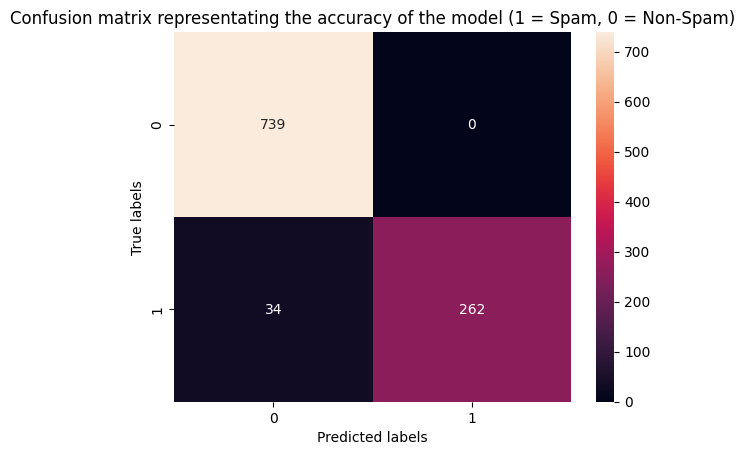

In [88]:
predictedResult = finalResult[1]
actualResult = finalResult[0]
cm = confusion_matrix(predictedResult, actualResult)
print("Accuracy : ", calculateAccuracy(predictedResult, actualResult), "%")
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Confusion matrix representating the accuracy of the model (1 = Spam, 0 = Non-Spam)')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()